In [35]:
import os
import pprint
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from os import listdir
from sklearn.metrics.pairwise import pairwise_distances

In [36]:
movies = pd.read_csv("ml-32m/movies.csv")
tags = pd.read_csv("ml-32m/tags.csv")
links = pd.read_csv("ml-32m/links.csv")
ratings = pd.read_csv("ml-32m/ratings.csv")

In [37]:
print("Películas:")
movies.head()

Películas:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [38]:
print("\nEtiquetas:")
tags.head()


Etiquetas:


,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


In [39]:
print("\nEnlaces:")
links.head()


Enlaces:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [40]:
print("\nRatings:")
ratings.head()


Ratings:


,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [41]:
most_active_user = ratings['userId'].value_counts().idxmax()
most_active_user_ratings = ratings['userId'].value_counts().max()
print(f"\nEl usuario con más calificaciones es {most_active_user} con {most_active_user_ratings} calificaciones.")



El usuario con más calificaciones es 175325 con 33332 calificaciones.


In [42]:
most_rated_movie = ratings['movieId'].value_counts().idxmax()
most_rated_movie_count = ratings['movieId'].value_counts().max()
movie_title = movies[movies['movieId'] == most_rated_movie]['title'].values[0]
print(f"\nLa película con más calificaciones es '{movie_title}' con {most_rated_movie_count} calificaciones.")



La película con más calificaciones es 'Shawshank Redemption, The (1994)' con 102929 calificaciones.


In [43]:
# Película mejor calificada (promedio más alto con al menos 100 calificaciones)
movie_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_ratings.columns = ['mean_rating', 'rating_count']
best_movie = movie_ratings[movie_ratings['rating_count'] >= 100].sort_values(by='mean_rating', ascending=False).head(1)
best_movie = best_movie.merge(movies, on='movieId')
print("\nPelícula mejor calificada:")
print(best_movie[['title', 'mean_rating', 'rating_count']])


Película mejor calificada:
                    title  mean_rating  rating_count
0  Planet Earth II (2016)      4.44683          1956


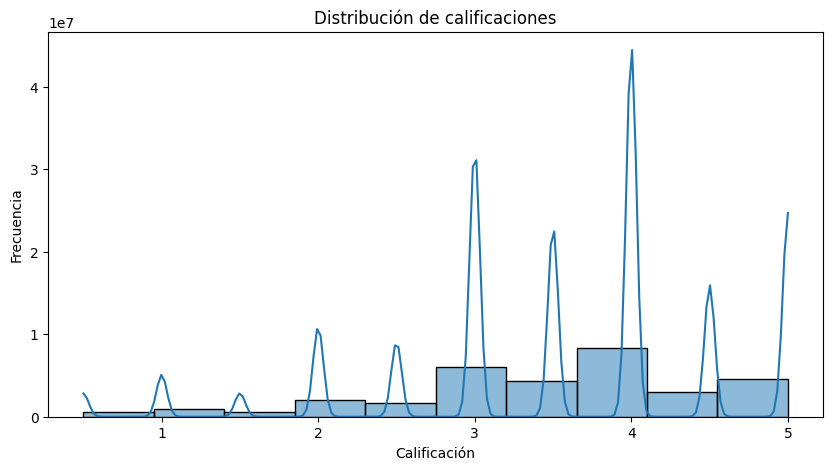

In [44]:
# Gráfica de la distribución de calificaciones
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.title('Distribución de calificaciones')
plt.show()


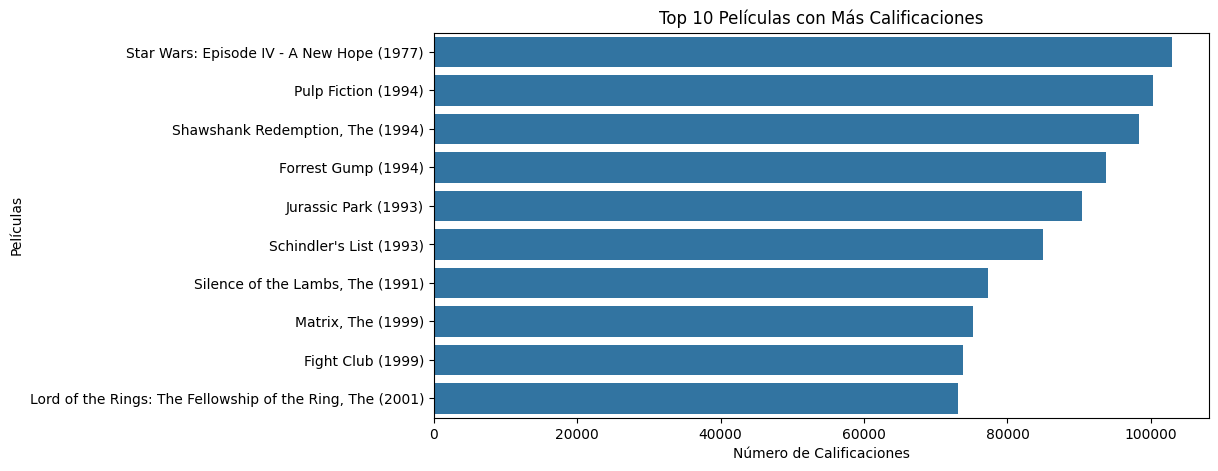

In [45]:
top_movies = ratings['movieId'].value_counts().head(10)
top_movie_titles = movies[movies['movieId'].isin(top_movies.index)]

plt.figure(figsize=(10, 5))
sns.barplot(y=top_movie_titles['title'], x=top_movies.values)
plt.xlabel('Número de Calificaciones')
plt.ylabel('Películas')
plt.title('Top 10 Películas con Más Calificaciones')
plt.show()

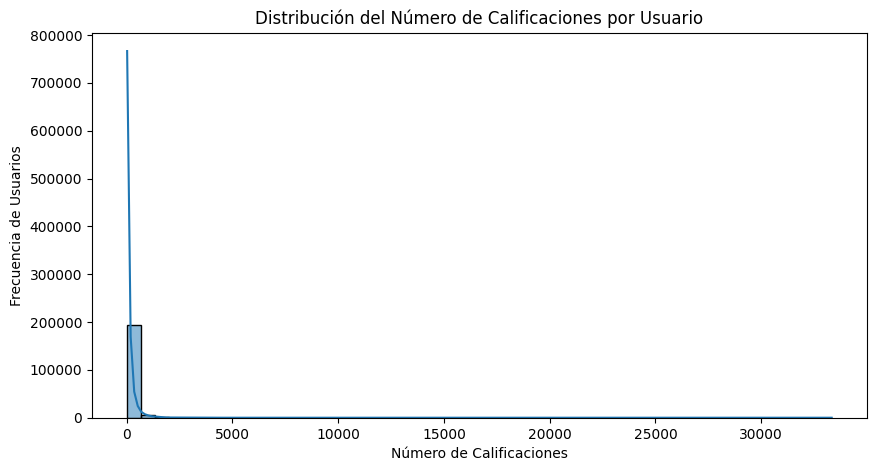

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(ratings['userId'].value_counts(), bins=50, kde=True)
plt.xlabel('Número de Calificaciones')
plt.ylabel('Frecuencia de Usuarios')
plt.title('Distribución del Número de Calificaciones por Usuario')
plt.show()

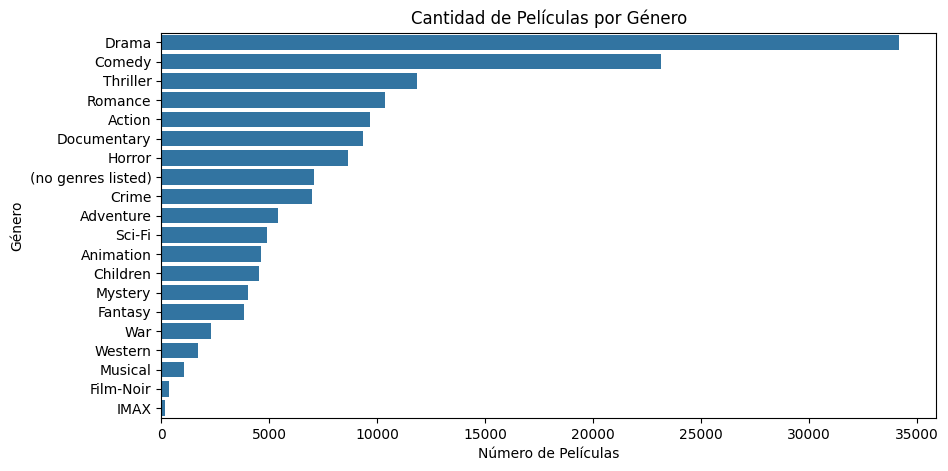

In [47]:
movies['genres'] = movies['genres'].str.split('|')
all_genres = [genre for sublist in movies['genres'].dropna() for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.xlabel('Número de Películas')
plt.ylabel('Género')
plt.title('Cantidad de Películas por Género')
plt.show()

In [48]:
# Usuarios que solo han dado calificaciones de 5.0
only_high_raters = ratings.groupby('userId')['rating'].unique().apply(lambda x: len(x) == 1 and x[0] == 5.0)
usuarios_solo_5 = only_high_raters[only_high_raters].index

print(f"Usuarios que solo califican con 5.0: {len(usuarios_solo_5)}")
ratings[ratings['userId'].isin(usuarios_solo_5)].head()


Usuarios que solo califican con 5.0: 359


,userId,movieId,rating,timestamp
298524,1913,1136,5.0,1522419490
298525,1913,1197,5.0,1522419427
298526,1913,1257,5.0,1522419589
298527,1913,1270,5.0,1522419583
298528,1913,1707,5.0,1522419617


In [49]:
# Usuarios que solo han dado calificaciones de 0.5
only_low_raters = ratings.groupby('userId')['rating'].unique().apply(lambda x: len(x) == 1 and x[0] == 0.5)
usuarios_solo_0_5 = only_low_raters[only_low_raters].index

print(f"Usuarios que solo califican con 0.5: {len(usuarios_solo_0_5)}")
ratings[ratings['userId'].isin(usuarios_solo_0_5)].head()



Usuarios que solo califican con 0.5: 14


,userId,movieId,rating,timestamp
813497,5333,318,0.5,1167308184
813498,5333,508,0.5,1167308315
813499,5333,524,0.5,1167308337
813500,5333,1193,0.5,1167308384
813501,5333,1225,0.5,1167308371


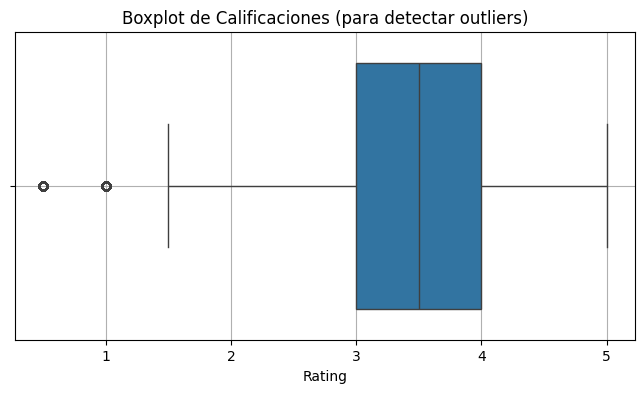

In [50]:
# Boxplot para visualizar valores extremos
plt.figure(figsize=(8, 4))
sns.boxplot(x=ratings["rating"])
plt.title("Boxplot de Calificaciones (para detectar outliers)")
plt.xlabel("Rating")
plt.grid(True)
plt.show()


In [51]:
print("Conclusiones preliminares del análisis de outliers:")
print(f"- Hay {len(usuarios_solo_5)} usuarios que solo califican con 5.0 (rating máximo).")
print(f"- Hay {len(usuarios_solo_0_5)} usuarios que solo califican con 0.5 (rating mínimo).")
print("- Estos comportamientos pueden indicar sesgo o patrones inusuales que deben analizarse antes de modelar.")


Conclusiones preliminares del análisis de outliers:
- Hay 359 usuarios que solo califican con 5.0 (rating máximo).
- Hay 14 usuarios que solo califican con 0.5 (rating mínimo).
- Estos comportamientos pueden indicar sesgo o patrones inusuales que deben analizarse antes de modelar.


In [52]:
# Extraer el año desde el título de la película
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype('float')

# Calcular nuevas variables:
user_mean = ratings.groupby('userId')['rating'].mean().rename('user_mean_rating')
user_count = ratings.groupby('userId')['rating'].count().rename('user_rating_count')
movie_mean = ratings.groupby('movieId')['rating'].mean().rename('movie_mean_rating')
movie_count = ratings.groupby('movieId')['rating'].count().rename('movie_rating_count')

# Unir todas las nuevas variables al dataframe de ratings
ratings_enriched = ratings.copy()
ratings_enriched = ratings_enriched.join(user_mean, on='userId')
ratings_enriched = ratings_enriched.join(user_count, on='userId')
ratings_enriched = ratings_enriched.join(movie_mean, on='movieId')
ratings_enriched = ratings_enriched.join(movie_count, on='movieId')

# Agregar el año de la película
ratings_enriched = ratings_enriched.merge(movies[['movieId', 'year']], on='movieId', how='left')

ratings_enriched.head()


,userId,movieId,rating,timestamp,user_mean_rating,user_rating_count,movie_mean_rating,movie_rating_count,year
0,1,17,4.0,944249077,3.531915,141,3.945126,22251,1995.0
1,1,25,1.0,944250228,3.531915,141,3.676182,22525,1995.0
2,1,29,2.0,943230976,3.531915,141,3.929884,9413,1995.0
3,1,30,5.0,944249077,3.531915,141,3.629615,1300,1995.0
4,1,32,5.0,943228858,3.531915,141,3.910185,55275,1995.0


In [53]:
# Evaluar correlación con la variable objetivo

# Calcular matriz de correlación entre rating y las nuevas variables
variables_interes = ['rating', 'user_mean_rating', 'user_rating_count',
                     'movie_mean_rating', 'movie_rating_count', 'year']

correlation_matrix = ratings_enriched[variables_interes].corr().round(3)

# Mostrar la matriz como texto
print("Matriz de correlación entre variables numéricas:")
correlation_matrix


Matriz de correlación entre variables numéricas:


,rating,user_mean_rating,user_rating_count,movie_mean_rating,movie_rating_count,year
rating,1.000,0.462,-0.111,0.429,0.209,-0.073
user_mean_rating,0.462,1.000,-0.241,0.182,0.144,0.011
user_rating_count,-0.111,-0.241,1.000,-0.129,-0.173,-0.005
movie_mean_rating,0.429,0.182,-0.129,1.000,0.486,-0.171
movie_rating_count,0.209,0.144,-0.173,0.486,1.000,-0.052
year,-0.073,0.011,-0.005,-0.171,-0.052,1.000


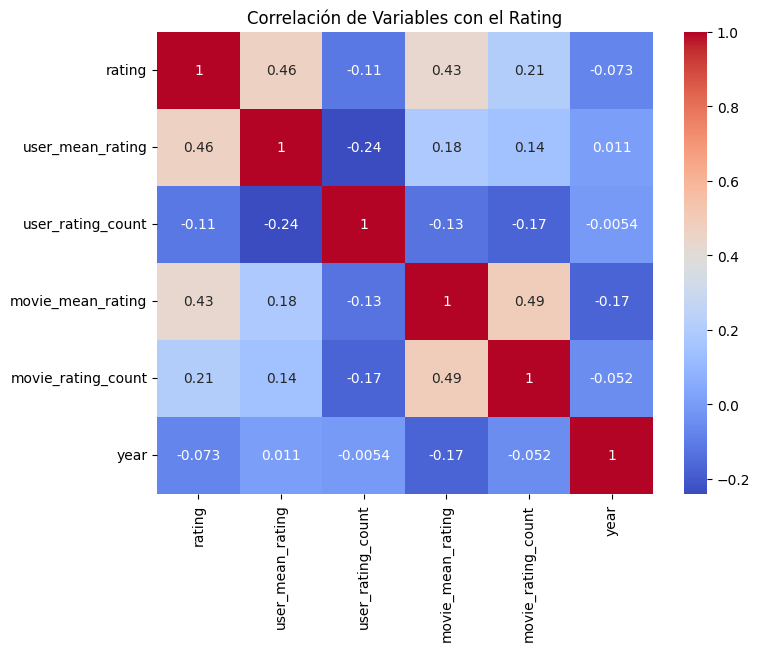

In [54]:
correlations = ratings_enriched[['rating', 'user_mean_rating', 'user_rating_count',
                                 'movie_mean_rating', 'movie_rating_count', 'year']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlación de Variables con el Rating")
plt.show()

In [55]:
# Calcular la desviación estándar de las calificaciones por usuario
user_std = ratings.groupby('userId')['rating'].std().rename('user_rating_std')

# Agregar la variable al DataFrame enriquecido
ratings_enriched = ratings_enriched.join(user_std, on='userId')

# Calcular la diferencia entre el rating y el promedio del usuario
ratings_enriched['rating_diff_user_mean'] = ratings_enriched['rating'] - ratings_enriched['user_mean_rating']

# Eliminar la columna 'year' por su baja correlación
ratings_enriched.drop(columns=['year'], inplace=True)

# Verificar resultado
ratings_enriched.head()


,userId,movieId,rating,timestamp,user_mean_rating,user_rating_count,movie_mean_rating,movie_rating_count,user_rating_std,rating_diff_user_mean
0,1,17,4.0,944249077,3.531915,141,3.945126,22251,1.53787,0.468085
1,1,25,1.0,944250228,3.531915,141,3.676182,22525,1.53787,-2.531915
2,1,29,2.0,943230976,3.531915,141,3.929884,9413,1.53787,-1.531915
3,1,30,5.0,944249077,3.531915,141,3.629615,1300,1.53787,1.468085
4,1,32,5.0,943228858,3.531915,141,3.910185,55275,1.53787,1.468085


In [56]:
# Seleccionamos todas las variables numéricas relevantes, sin incluir 'year'
variables_actuales = [
    'rating',
    'user_mean_rating',
    'user_rating_count',
    'user_rating_std',
    'movie_mean_rating',
    'movie_rating_count',
    'rating_diff_user_mean'
]

# Calcular y mostrar la matriz de correlación
correlation_matrix = ratings_enriched[variables_actuales].corr().round(3)

print("Matriz de correlación actualizada:")
correlation_matrix


Matriz de correlación actualizada:


,rating,user_mean_rating,user_rating_count,user_rating_std,movie_mean_rating,movie_rating_count,rating_diff_user_mean
rating,1.000,0.462,-0.111,-0.204,0.429,0.209,0.887
user_mean_rating,0.462,1.000,-0.241,-0.442,0.182,0.144,0.000
user_rating_count,-0.111,-0.241,1.000,-0.025,-0.129,-0.173,-0.000
user_rating_std,-0.204,-0.442,-0.025,1.000,-0.074,-0.028,-0.000
movie_mean_rating,0.429,0.182,-0.129,-0.074,1.000,0.486,0.389
movie_rating_count,0.209,0.144,-0.173,-0.028,0.486,1.000,0.160
rating_diff_user_mean,0.887,0.000,-0.000,-0.000,0.389,0.160,1.000


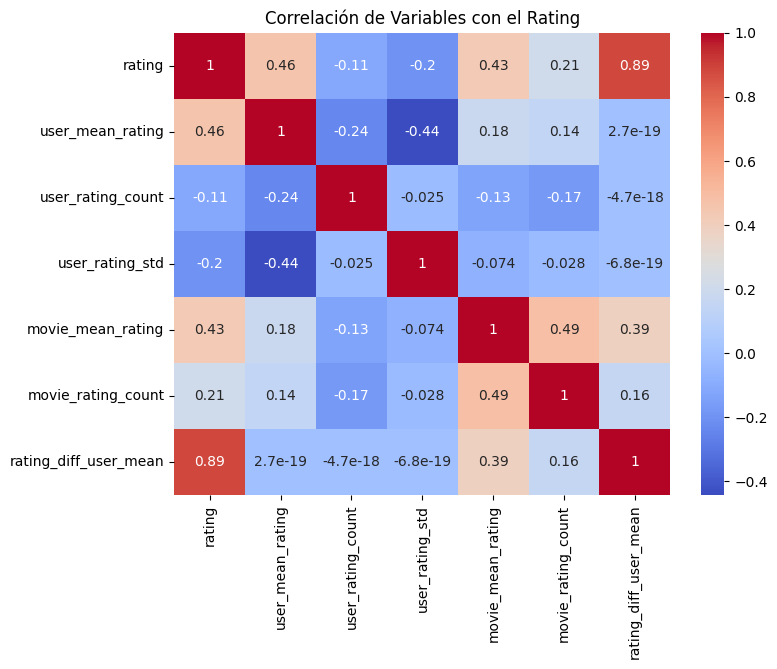

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(ratings_enriched[variables_actuales].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación de Variables con el Rating")
plt.show()

In [58]:
# Eliminar la variable que puede causar data leakage
ratings_enriched.drop(columns=['rating_diff_user_mean'], inplace=True)

# Verificar columnas actuales
print("Variables disponibles para el modelo:")
print(ratings_enriched.columns)


Variables disponibles para el modelo:
Index(['userId', 'movieId', 'rating', 'timestamp', 'user_mean_rating',
       'user_rating_count', 'movie_mean_rating', 'movie_rating_count',
       'user_rating_std'],
      dtype='object')
